# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf
import prettytensor as pt
import math
import warnings
from tqdm import trange
from sklearn.utils import shuffle
import skimage
from skimage import color
from skimage import exposure
from skimage import transform
import random
%matplotlib inline

In [2]:
training_file = "datasets/train.p"
validation_file= "datasets/valid.p"
testing_file = "datasets/test.p"

# Open file using pickle
def open_file(input_file):
    with open(input_file, mode='rb') as f:
        file = pickle.load(f)
    return file['features'], file['labels']
    
X_train, y_train = open_file(training_file)
X_valid, y_valid = open_file(validation_file)
X_test, y_test = open_file(testing_file)

---

## Step 1: Dataset Summary & Visualization

### Dataset Summary

In [3]:
print("Image Shape:    {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))
print()

Image Shape:    (32, 32, 3)
Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples



In [4]:
signnames = pd.read_csv('signnames.csv')
signnames.iloc[:,:]

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

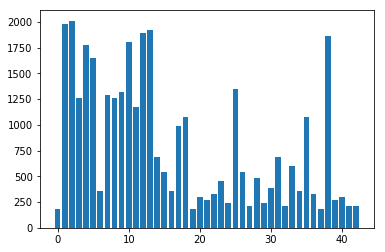

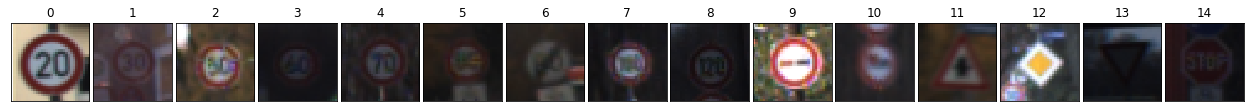

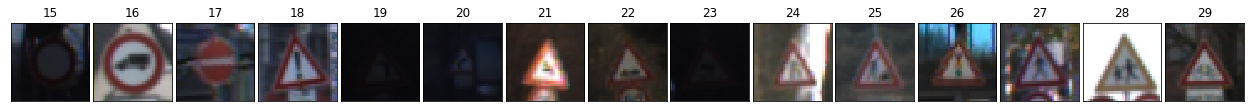

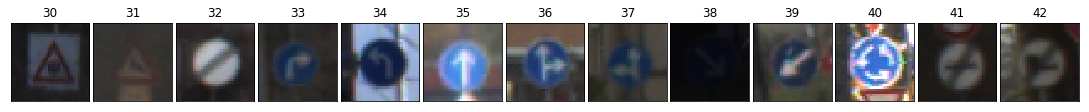

In [5]:
train_classes = np.unique(y_train, return_index = True, return_counts = True)

#Displays class distribution and class examples
def display_data(x, y):
    classes = np.unique(y, return_index = True, return_counts = True)
    plt.bar(np.arange(43), classes[2])

    plt.show()
    c=0
    for i in range(0,5):
        fig = plt.figure(figsize=(6,1))
        fig.subplots_adjust(left = 0, right = 4, bottom = 0, top = 3, hspace = 0.05, wspace = 0.05)
        for n in range(0,15):
            if c <= 42:
                row = fig.add_subplot(1,21, n+1, xticks=[],yticks=[])
                row.set_title(classes[0][c])
                row.imshow(x[classes[1][c]])
                c+=1
            else:
                i=5
                break
    plt.show()
    
display_data(X_train, y_train)

As you can see, the data is not very uniform. Some classes have less than 200 examples, while others have around 2000. This is not a good dataset to train a neural network with, as the neural net will be much more likely to classify an image it is uncertain of within a class that has more examples. More examples are required in the classes that have fewer examples, so we will augment images within those classes so that we have a more uniform dataset.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
# Uses the LAB colorspace, as it isolates color, lightness, and chroma into different axes 
def rgb2lab(x):
    x_output=[]
    for i in trange(x.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x_lab=color.rgb2lab(x[i])
            x_output.append(x_lab)
    return (np.asarray(x_output))

# Applies adaptive histogram equalization to normalize data
def histeq(x):
    x_output=[]
    for i in trange(x.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x_hist=exposure.equalize_adapthist(x[i])
            x_output.append(x_hist)
    return (np.asarray(x_output))

#Calculates required number of examples per class, then augments examples by randomly scaling, rotating, translating, and shearing images from original dataset
def augment(x, y):
    x_output= []
    y_output= []
    classes = np.unique(y, return_index = True, return_counts = True)
    maxclass = []
    maxclass = np.argmax(classes[2])
    for z in range(x.shape[0]):
        x_output.append(x[z])
        y_output.append(y[z])
    for i in trange(len(classes[0])):
        req_images = classes[2][maxclass] - classes[2][i]
        indices = []
        for z in range(req_images):
            indices = random.choice(range(classes[1][i], classes[1][i]+classes[2][i]))
            tform = transform.AffineTransform(scale = (random.uniform(0.9,1.1), random.uniform(0.9,1.1)),rotation = random.uniform(-0.5,0.5), translation = (random.uniform(-5,5), random.uniform(-5,5)))
            img = transform.warp(x[indices], tform, output_shape=(32,32), order = 1, mode = 'edge')
            x_output.append(img)
            y_output.append(y[indices])
    return (np.asarray(x_output), np.asarray(y_output))


    # string = ''.join([random.choice(x) for _ in range(v)])

#We'll be saving these images in order to be able to access them later without needing to re-run the preprocessing
def save_image(x, y, file):
    with open(file, 'wb') as pfile:
        pickle.dump(
            {
                'features': x,
                'labels': y
            },
            pfile, pickle.HIGHEST_PROTOCOL)
        
def preprocess(x, y, imgaug):
    x_= []
    y_ = []
    x_ = histeq(x)
    x_ = rgb2lab(x_)
    if imgaug == True: #Augmentation isn't necessary for validation and testing, so we enable it via the imgaug bool
        x_, y_ = augment(x_, y)
        return np.asarray(x_), np.asarray(y_)
    else:
        return np.asarray(x_)

In [7]:
import os.path

if os.path.isfile("datasets/_train.p") == False:
    X_train_, y_train_ = preprocess(X_train, y_train, imgaug=True)
    X_valid_ = preprocess(X_valid, y_train, imgaug=False)
    X_test_= preprocess(X_test, y_train, imgaug=False)
    save_image(X_train_, y_train_, "datasets/_train.p")
    save_image(X_valid_, y_valid, "datasets/_valid.p")
    save_image(X_test_, y_test, "datasets/_test.p")
else:
    training_file = "datasets/_train.p"
    validation_file= "datasets/_valid.p"
    testing_file = "datasets/_test.p"    
    X_train_, y_train_ = open_file(training_file)
    X_valid_, y_valid_ = open_file(validation_file)
    X_test_, y_test_ = open_file(testing_file)
print(X_train.shape)

100%|██████████| 12630/12630 [00:06<00:00, 1875.05it/s]


(34799, 32, 32, 3)


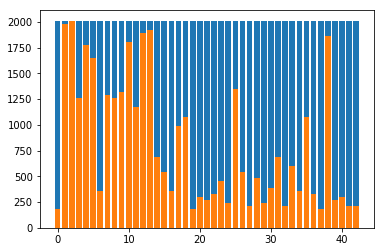

original vs preprocessed
2717
1
augmented image
54630
21
(86430, 32, 32, 3)


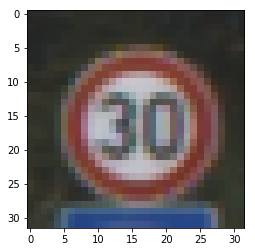

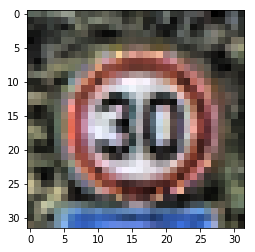

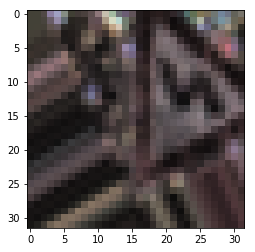

In [8]:
#Orange represents original dataset, blue represents augmented dataset
aug_classes = np.unique(y_train_, return_index = True, return_counts = True)
plt.bar(np.arange(43), aug_classes[2])
plt.bar(np.arange(43), train_classes[2])
plt.show()


print("original vs preprocessed")
index = random.randint(0, 34790)
print(index)
print(y_train[index])
image = X_train[index]
image_proc = X_train_[index]
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(color.lab2rgb(image_proc))




print("augmented image")
index = random.randint(34799, len(X_train_))
print(index)
print(y_train_[index])
print(X_train_.shape)
image = X_train_[index].squeeze()
plt.figure()
plt.imshow(color.lab2rgb(image))

### Model Architecture

In [9]:
EPOCHS = 50
BATCH_SIZE = 64
rate = 0.0008

from tensorflow.contrib.layers import flatten

def leaky_relu(x):
    return tf.maximum(tf.scalar_mul(-0.1, x), x)

def LeNet(x, prob=1.0):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID', name="con1") + conv1_b

    #  Activation.
    conv1 = leaky_relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 26), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(26))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID',name="con2") + conv2_b
    
    # Activation.
    conv2 = leaky_relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(650, 150), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(150))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = leaky_relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(150, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = leaky_relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate= rate)
training_operation = optimizer.minimize(loss_operation)

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, prob=1.0):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_, y_train_ = shuffle(X_train_, y_train_)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_[offset:end], y_train_[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid_, y_valid)
        accuracy.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'model/lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.721

EPOCH 2 ...
Validation Accuracy = 0.830

EPOCH 3 ...
Validation Accuracy = 0.859

EPOCH 4 ...
Validation Accuracy = 0.885

EPOCH 5 ...
Validation Accuracy = 0.895

EPOCH 6 ...
Validation Accuracy = 0.897

EPOCH 7 ...
Validation Accuracy = 0.914

EPOCH 8 ...
Validation Accuracy = 0.908

EPOCH 9 ...
Validation Accuracy = 0.920

EPOCH 10 ...
Validation Accuracy = 0.891

EPOCH 11 ...
Validation Accuracy = 0.915

EPOCH 12 ...
Validation Accuracy = 0.920

EPOCH 13 ...
Validation Accuracy = 0.914

EPOCH 14 ...
Validation Accuracy = 0.910

EPOCH 15 ...
Validation Accuracy = 0.926

EPOCH 16 ...
Validation Accuracy = 0.922

EPOCH 17 ...
Validation Accuracy = 0.905

EPOCH 18 ...
Validation Accuracy = 0.895

EPOCH 19 ...
Validation Accuracy = 0.934

EPOCH 20 ...
Validation Accuracy = 0.918

EPOCH 21 ...
Validation Accuracy = 0.941

EPOCH 22 ...
Validation Accuracy = 0.930

EPOCH 23 ...
Validation Accuracy = 0.932

EPOCH 24 ...
Validation Accura

In [13]:
# Evaluate the Model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    test_accuracy = evaluate(X_test_, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from model/lenet
Test Accuracy = 0.946


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

/home/kemfic/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 10/10 [00:00<00:00, 1659.40it/s]


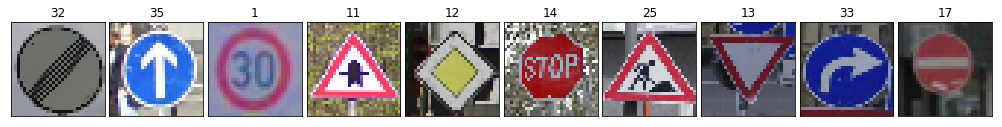

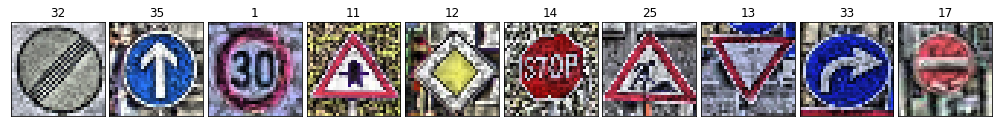

In [32]:
import glob
import imageio
def resize_img(img):
    img_ = transform.resize(img, output_shape=[32,32])
    img_ = img_[...,:3]
    return img_

custom_img = []
custom_label = []
for image_path in glob.glob("custom_images/*.png"):
    (name,ext) = os.path.splitext(image_path)
    name = name[14::]
    custom_label.append(int(name))
    im = imageio.imread(image_path)
    img = resize_img(im)
    custom_img.append(img)

custom_img = np.array(custom_img)
custom_label = np.array(custom_label)

c_x = preprocess(x=custom_img, y=None, imgaug=False)


imgfig = plt.figure(figsize=(3,1))
imgfig.subplots_adjust(left = 0, right = 5, bottom = 0, top = 5, hspace = 0.05, wspace = 0.05)
for i in range(len(custom_img)):
    row = imgfig.add_subplot(1,11, i+1, xticks=[],yticks=[])
    row.set_title(custom_label[i])
    row.imshow(custom_img[i])
plt.show()

imgfig = plt.figure(figsize=(3,1))
imgfig.subplots_adjust(left = 0, right = 5, bottom = 0, top = 5, hspace = 0.05, wspace = 0.05)
for i in range(len(custom_img)):
    row = imgfig.add_subplot(1,11, i+1, xticks=[],yticks=[])
    row.set_title(custom_label[i])
    row.imshow(color.lab2rgb(c_x[i]))
plt.show()

### Predict the Sign Type for Each Image

In [30]:
import tensorflow as tf

test_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
test_operation = tf.reduce_mean(tf.cast(test_prediction, tf.float32))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    accuracy = sess.run(test_operation, feed_dict={x: c_x, y: custom_label})
    print("Accuracy = {:.3f}".format(accuracy))

INFO:tensorflow:Restoring parameters from model/lenet
Accuracy = 1.000


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from model/lenet
Top 5 Predictions


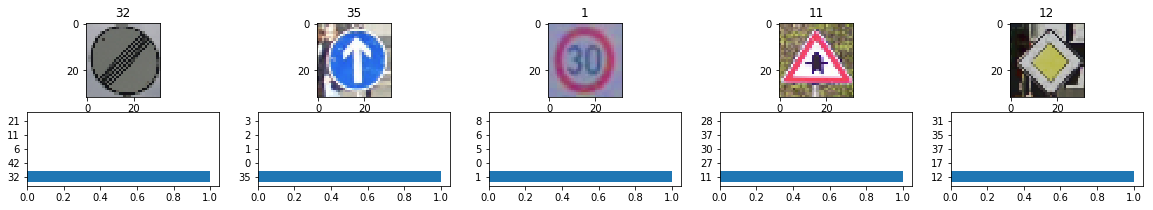

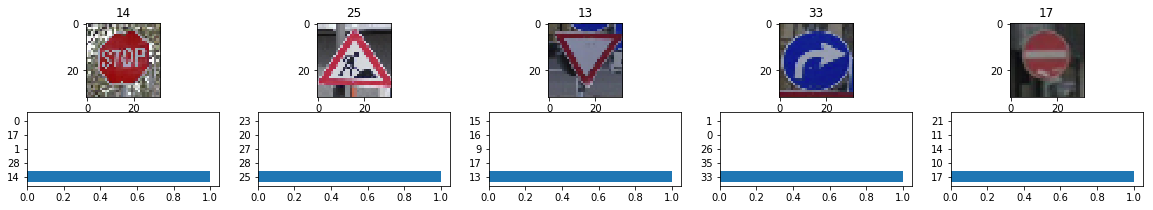

Top 5 Predictions(Log Scale)


/home/kemfic/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


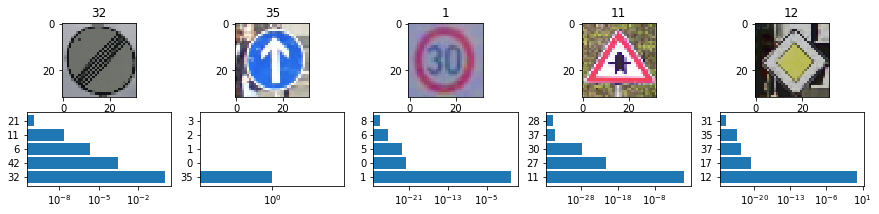

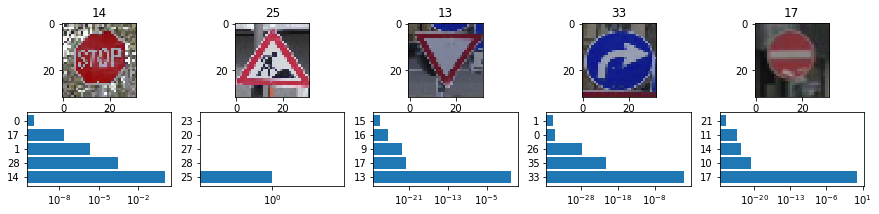

[[  9.99732554e-01   2.65222363e-04   2.24217388e-06   2.28567920e-08
    1.11911640e-10]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   3.01360845e-22   3.79897678e-23   7.48541731e-26
    1.27276226e-27]
 [  1.00000000e+00   6.12055896e-22   1.96884183e-28   1.32070937e-35
    3.07229805e-36]
 [  1.00000000e+00   2.69703733e-21   3.02830007e-23   5.28964764e-24
    3.50334268e-26]
 [  1.00000000e+00   2.07396171e-32   2.53381958e-33   1.30630899e-35
    0.00000000e+00]
 [  9.99999881e-01   1.42423929e-07   1.02102707e-15   7.72091376e-17
    1.79058026e-20]
 [  1.00000000e+00   1.61541804e-14   8.74737860e-16   3.91657095e-20
    1.20125744e-22]
 [  9.07319307e-01   9.26807299e-02   8.94925000e-36   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   1.03715827e-21   2.62327450e-24   3.19978508e-27
    1.11496543e-27]]


In [31]:
top_k = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=top_k), feed_dict={x:c_x})

z=0
print("Top 5 Predictions")
for n in range(2):
    f = plt.figure(figsize=(20,3))
    ax = f.subplots(2, 5, sharey=False, sharex=False)
    for i in range(int(len(custom_label)/2)):
        ax[0,i].set_title(custom_label[i+z])
        ax[0,i].imshow(custom_img[i+z])
        ax[1,i].barh(range(top_k), top.values[i])
        ax[1,i].set_yticks(range(top_k))
        ax[1,i].set_yticklabels(train_classes[0][top[1][i+z]])
    z=5
    plt.show()

z=0
print("Top 5 Predictions(Log Scale)")
for n in range(2):
    f = plt.figure(figsize=(15,3))
    ax = f.subplots(2, 5, sharey=False, sharex=False)
    for i in range(int(len(custom_label)/2)):
        ax[0,i].set_title(custom_label[i+z])
        ax[0,i].imshow(custom_img[i+z])
        ax[1,i].barh(range(top_k), top.values[i], log=True)
        ax[1,i].set_yticks(range(top_k))
        ax[1,i].set_yticklabels(train_classes[0][top[1][i+z]])
    z=5
    plt.show()
print(top.values)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [17]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from model/lenet


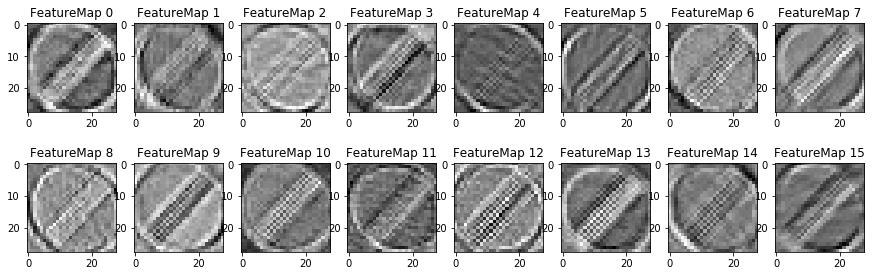

In [34]:
with tf.Session() as sess:
    # Convolution (layer 1 after 'tf.nn.conv2d' operation)
    saver.restore(sess, tf.train.latest_checkpoint('model/'))
    conv1 = sess.graph.get_tensor_by_name('con1:0')
    outputFeatureMap(c_x, conv1)
    plt.savefig('conv1.png')